# Load Data

In [25]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle

In [26]:
def load_data(fname):
    f = open(fname, "rb")
    data = pickle.load(f)
    f.close()
    return data

def remove_outlier_std(df_in, col_name):
    mean = df_in[col_name].mean()
    std  = df_in[col_name].std() 
    step = 3

    fence_low  = mean - std*step
    fence_high = mean + std*step
    df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [27]:
# Loading object file is faster than loading xlsx file
data = load_data("wagedata.dat")
data["married"][data["married"] != 1] = 0

C:\Users\nghia\AppData\Local\Temp\ipykernel_3792\3072225324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["married"][data["married"] != 1] = 0


# Select Variable

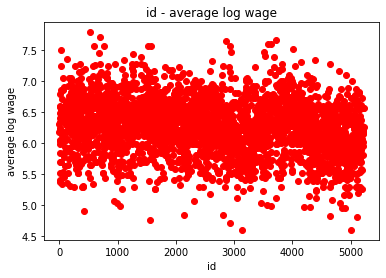

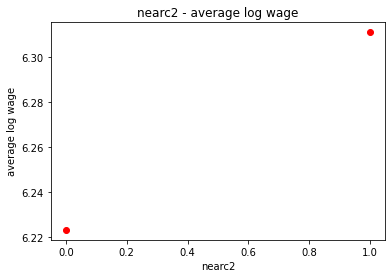

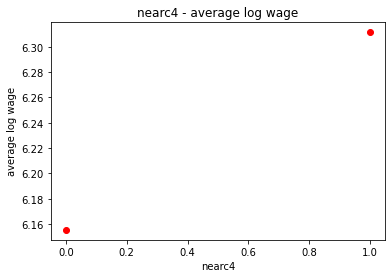

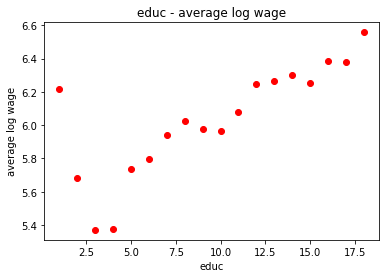

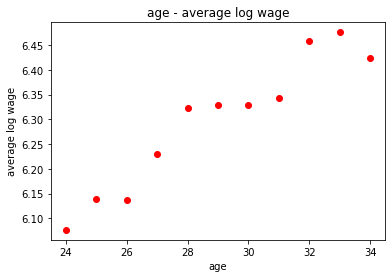

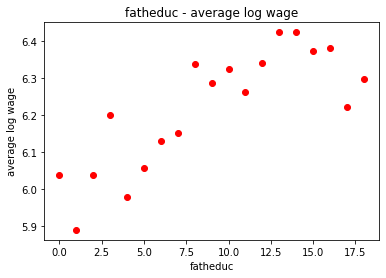

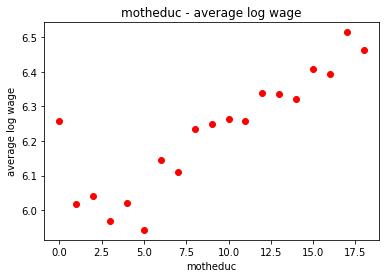

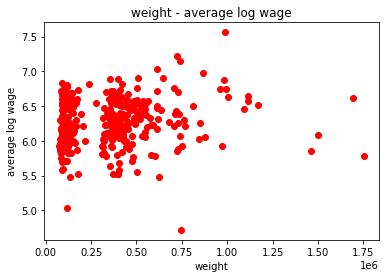

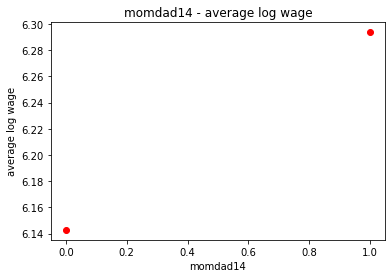

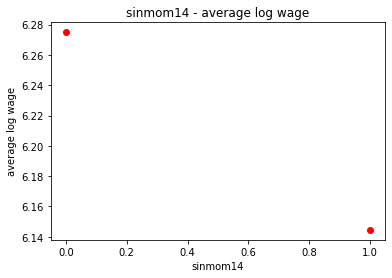

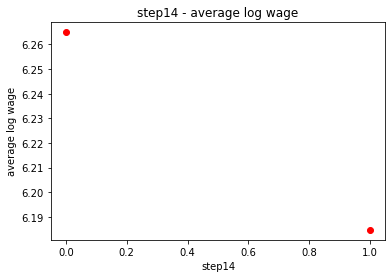

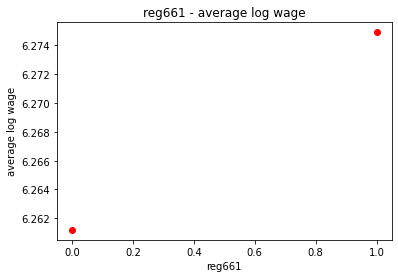

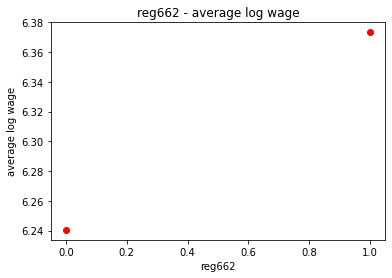

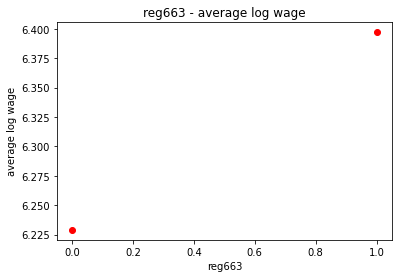

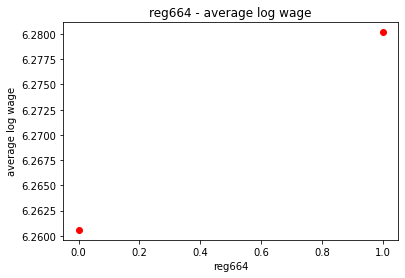

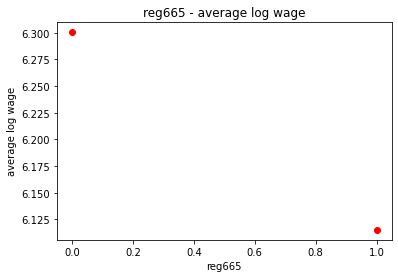

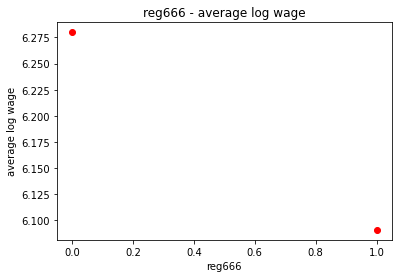

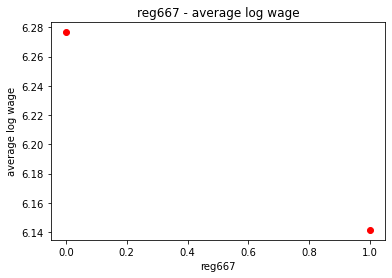

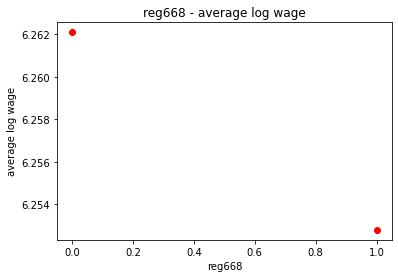

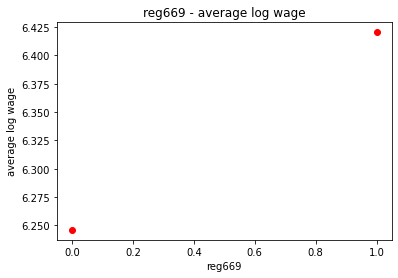

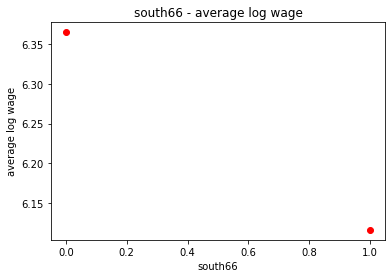

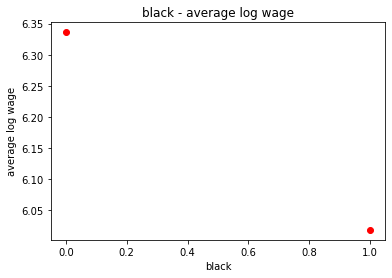

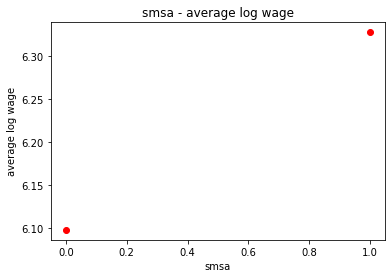

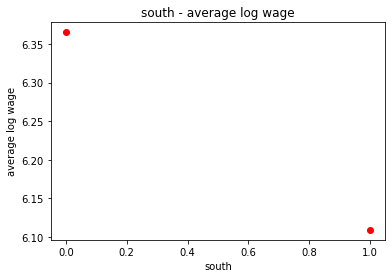

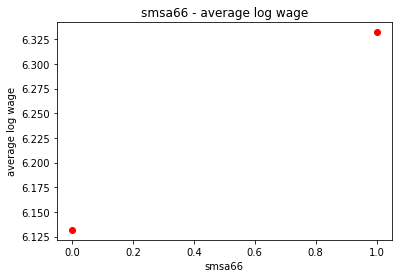

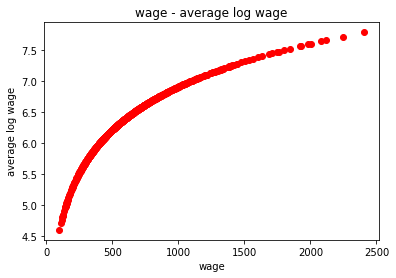

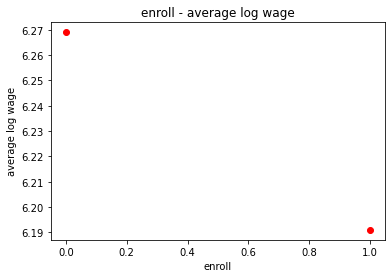

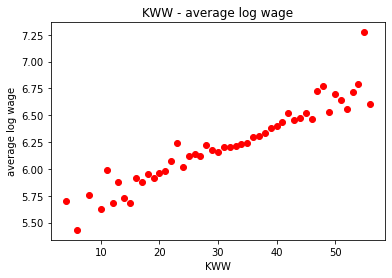

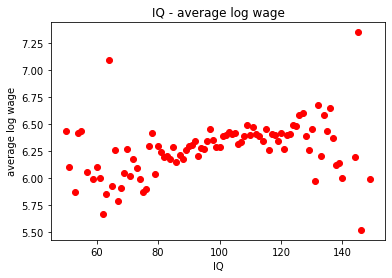

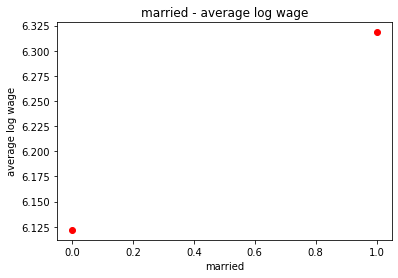

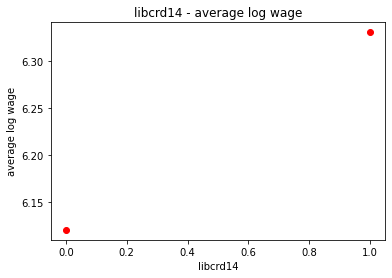

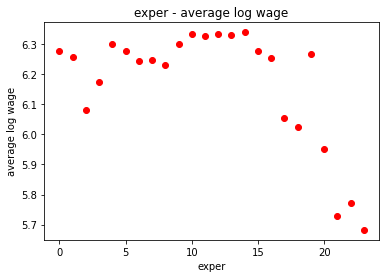

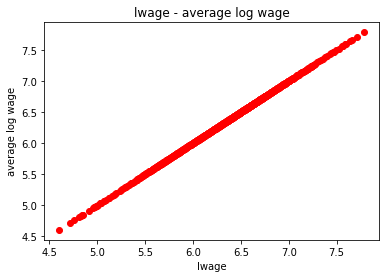

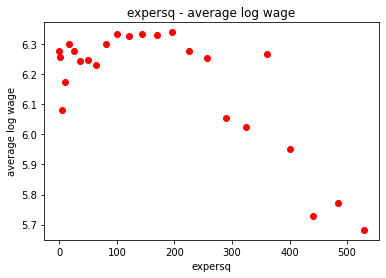

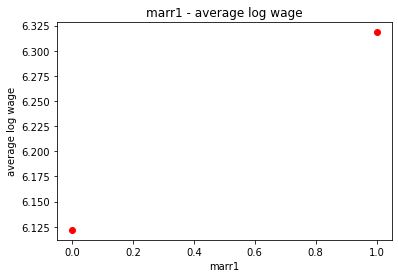

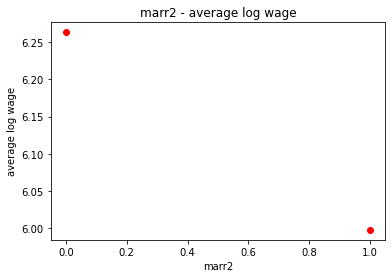

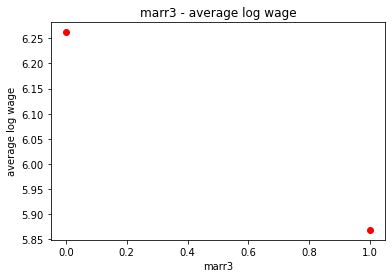

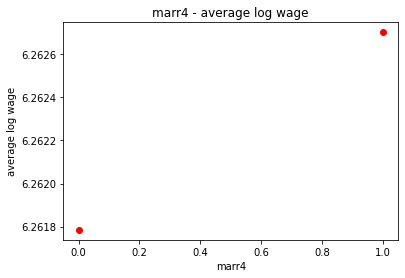

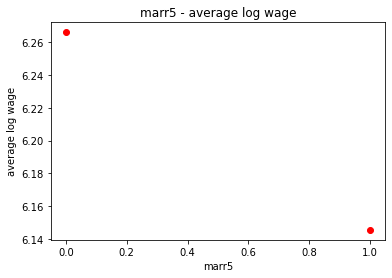

In [28]:
# Display mean of data points
for x in data.columns:
    plt.cla()
    plt.xlabel(x)
    plt.ylabel("average log wage")
    plt.title(x+" - average log wage")
    for dtx in set(data[x]):
        y = data[data[x] == dtx]["lwage"].mean()
        plt.plot(dtx, y, "ro")
    plt.show()

# Train Model

In [29]:
# Variables to train model
data_vars = ["educ","exper","expersq","KWW","black","smsa","married","enroll","south",'reg661','reg662','reg663','reg664','reg665','reg666','reg667','reg668']
# Remove NaN rows and outliers
data_ = data[data_vars + ["lwage"]].dropna()
print("Before remove outliers: {0}".format(data_.shape))
data_ = remove_outlier_std(data_, "lwage")
print("After remove outliers: {0}".format(data_.shape))
# Just use some variable in data
X_data = data_[data_vars]
# Add ones to first column of matrix
X = np.concatenate((np.ones(shape=(data_.shape[0],1)) , np.array(X_data)), axis=1)
# Log wage is the output
Y = np.array(data_["lwage"]).reshape(len(data_["lwage"]), 1)
# Split data to train and test, shuffle the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, shuffle=False)

print("X train shape: {0} \nY train shape: {1}".format(X_train.shape, Y_train.shape))

print("X test shape: {0} \nY test shape: {1}".format(X_test.shape, Y_test.shape))

Before remove outliers: (2963, 18)
After remove outliers: (2949, 18)
X train shape: (2654, 18) 
Y train shape: (2654, 1)
X test shape: (295, 18) 
Y test shape: (295, 1)


In [30]:
# Caculate inverse of X_T @ X 
X_TX_inverse = np.linalg.inv(X_train.transpose() @ X_train)
# Caculate beta
beta = X_TX_inverse @ X_train.transpose() @ Y_train

# Use library to caculate beta
reg = LinearRegression()
reg.fit(X_train, Y_train)
beta_ = reg.coef_.transpose()
beta_[0,0] += reg.intercept_
print("my beta: \n{0}".format(beta.T))
print("sklearn beta: \n{0}".format(beta_.T))

my beta: 
[[ 4.86022202e+00  5.32828499e-02  5.62511775e-02 -1.52146205e-03
   7.98181866e-03 -1.24599347e-01  1.37477151e-01  1.40325151e-01
  -1.30659267e-01 -1.36356426e-01 -1.36604992e-01 -3.74880165e-02
   1.25380056e-02 -8.66905816e-02 -4.31047850e-04  4.51402266e-03
  -1.60259327e-03 -1.84796472e-01]]
sklearn beta: 
[[ 4.86022202e+00  5.32828499e-02  5.62511775e-02 -1.52146205e-03
   7.98181866e-03 -1.24599347e-01  1.37477151e-01  1.40325151e-01
  -1.30659267e-01 -1.36356426e-01 -1.36604992e-01 -3.74880165e-02
   1.25380056e-02 -8.66905816e-02 -4.31047850e-04  4.51402266e-03
  -1.60259327e-03 -1.84796472e-01]]


In [31]:
# Save our beta to file
np.save("beta.npy", beta)

# Evaluate Model

In [32]:
# Caculate train error (MSE)
train_error = np.linalg.norm(Y_train - X_train @ beta)**2 / Y_train.shape[0]
# Caculate test error (MSE)
test_error = np.linalg.norm(Y_test - X_test @ beta)**2 / Y_test.shape[0]
# Caculate the score to evaluate the effeciency (R-square)
train_score = 1 - np.linalg.norm(Y_train - X_train @ beta) ** 2 / np.linalg.norm(Y_train - Y_train.mean()) ** 2
test_score = 1 - np.linalg.norm(Y_test - X_test @ beta) ** 2 / np.linalg.norm(Y_test - Y_test.mean()) ** 2
print("Train error: {0}".format(train_error))
print("Test error: {0}".format(test_error))
print("Train R-square: {0}".format(train_score))
print("Test R-square: {0}".format(test_score))

Train error: 0.12520220965397558
Test error: 0.11695983903492911
Train R-square: 0.30355029217701957
Test R-square: 0.3020533950391344


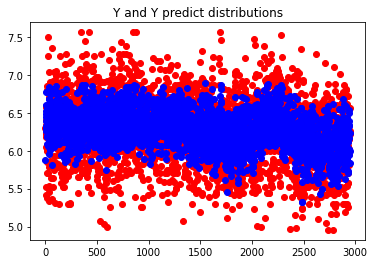

In [33]:
plt.plot(np.arange(0,Y.shape[0]),Y, 'ro')
plt.plot(np.arange(0,Y.shape[0]),X @ beta, 'bo')
plt.title("Y and Y predict distributions")
plt.savefig("./distributions/y_and_y_pred.png")
plt.show()

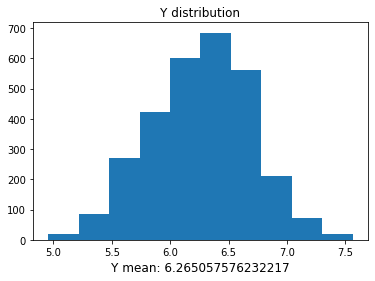

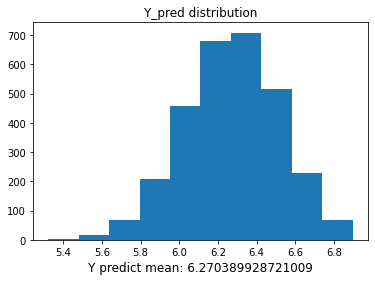

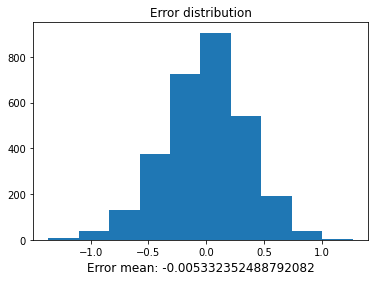

In [34]:
# Display distributions (Create distributions folder before run this code)
plt.hist(Y)
plt.title("Y distribution")
plt.xlabel("Y mean: {0}".format(Y.mean()), fontsize=12)
plt.savefig("./distributions/y_dis.png")
plt.show()
plt.hist(X @ beta)
plt.title("Y_pred distribution")
plt.savefig("./distributions/y_pred_dis.png")
plt.xlabel("Y predict mean: {0}".format((X @ beta).mean()), fontsize=12)
plt.show()
plt.hist(Y - X @ beta)
plt.title("Error distribution")
plt.savefig("./distributions/error_dis.png")
plt.xlabel("Error mean: {0}".format((Y - X @ beta).mean()), fontsize=12)
plt.show()

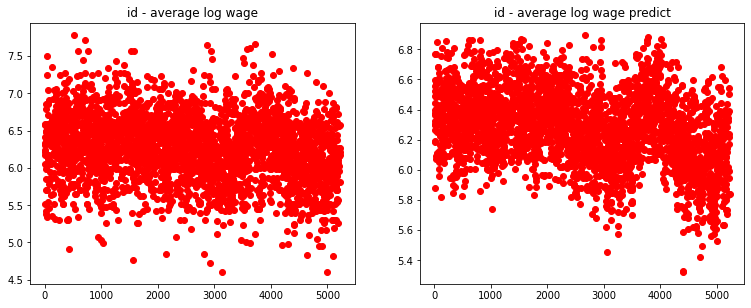

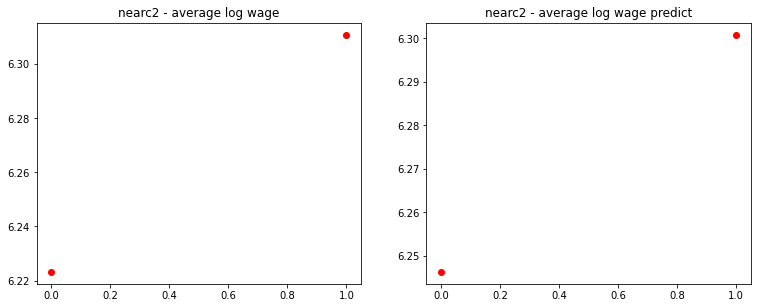

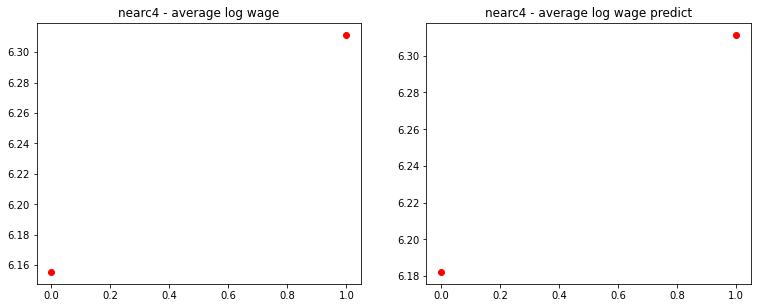

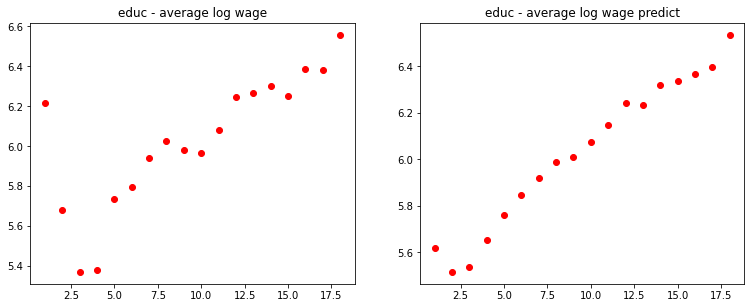

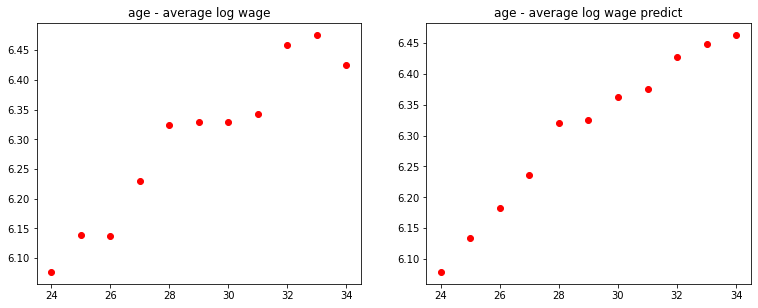

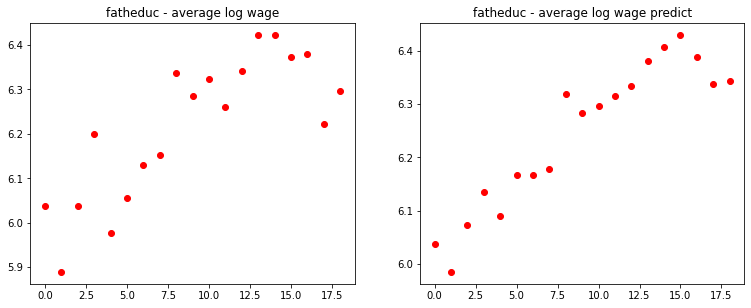

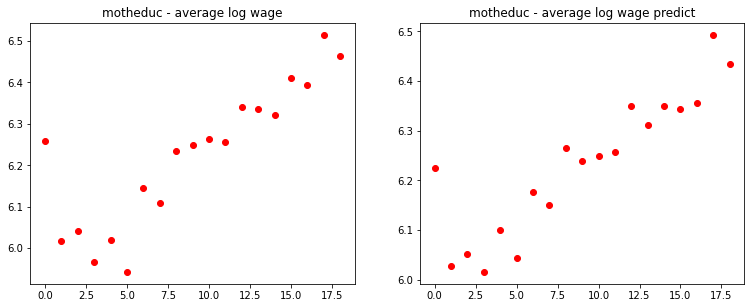

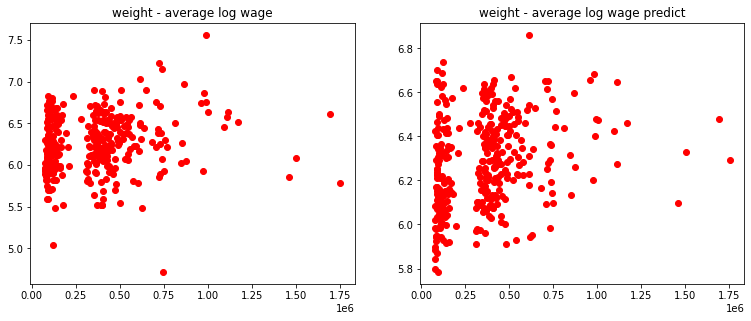

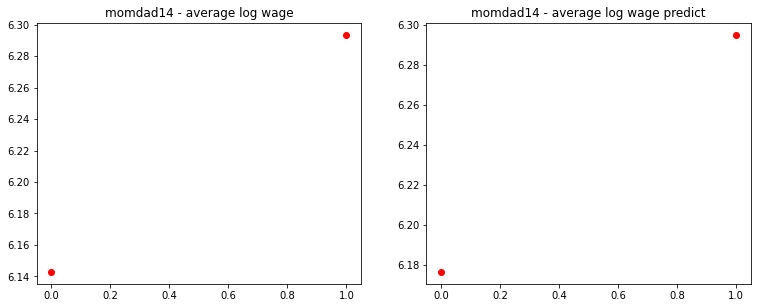

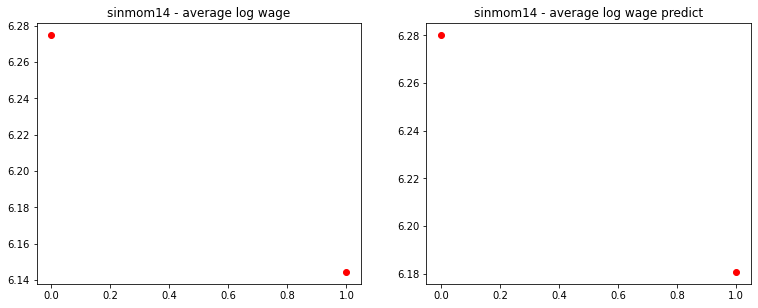

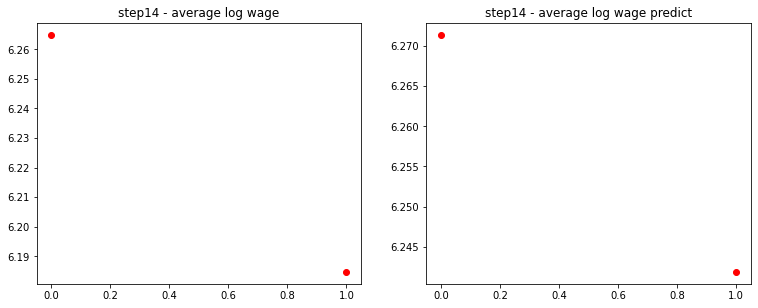

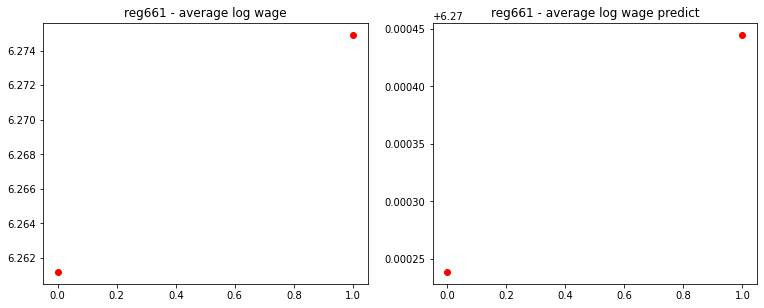

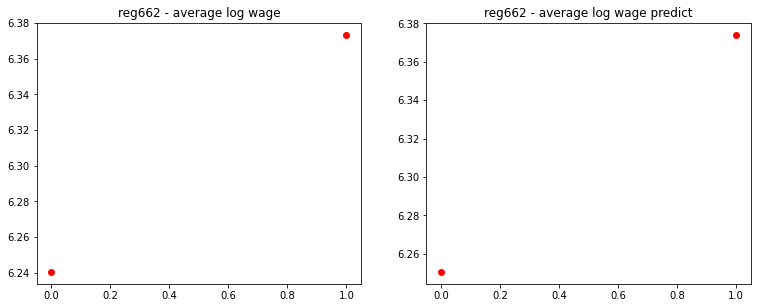

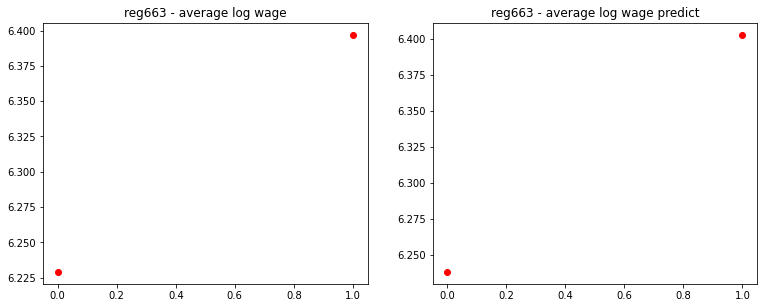

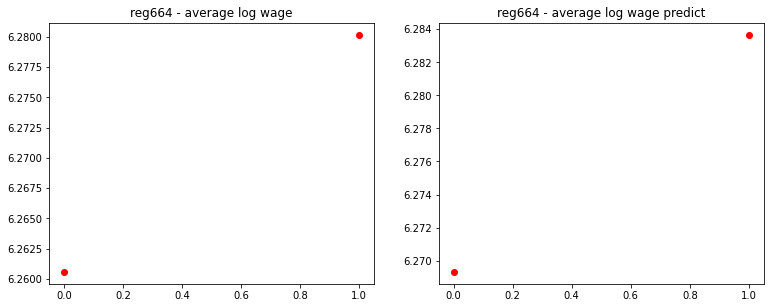

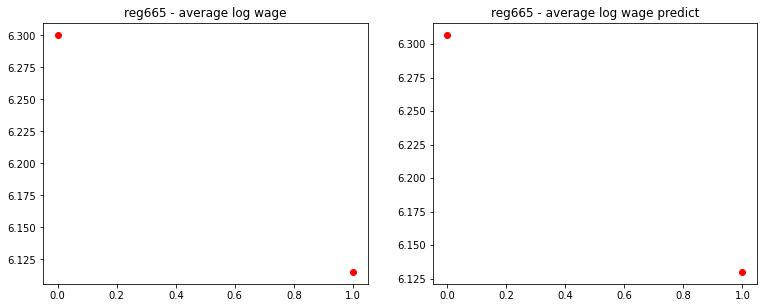

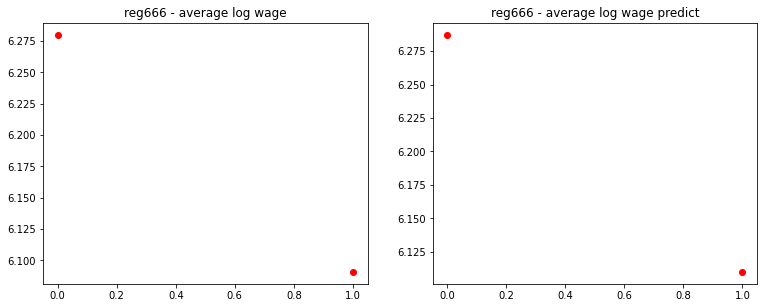

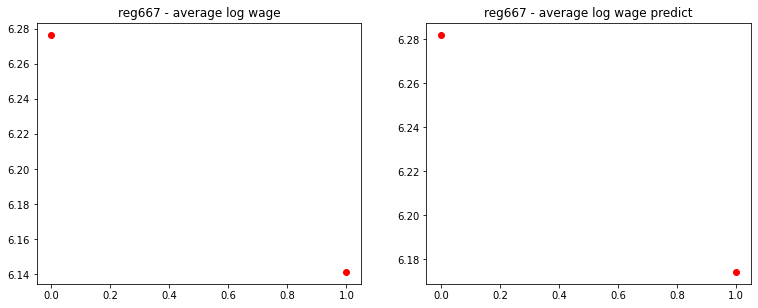

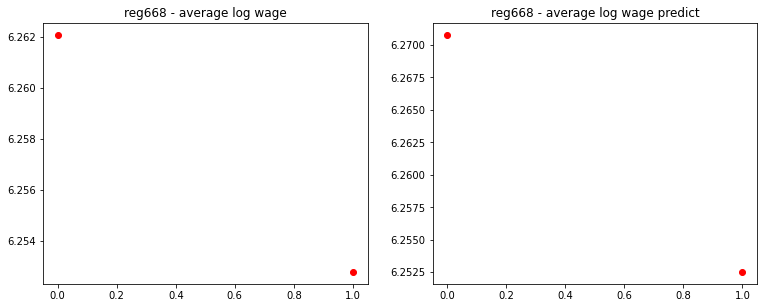

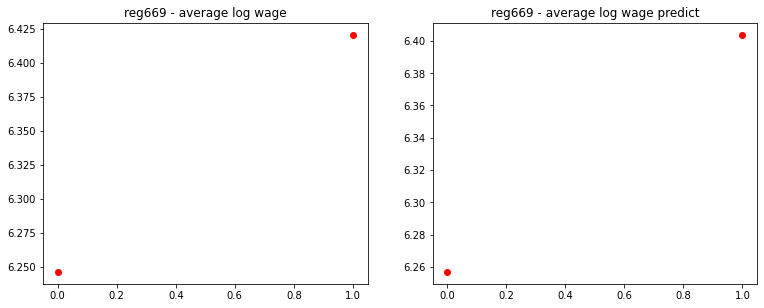

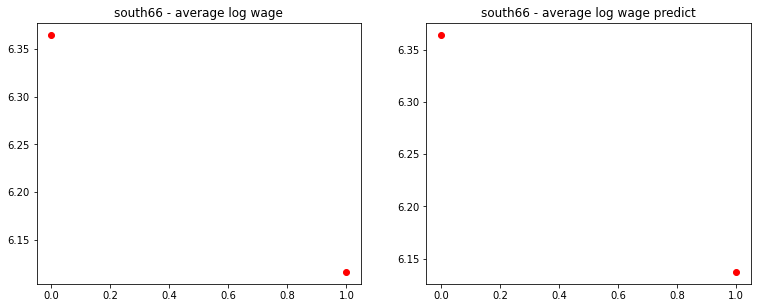

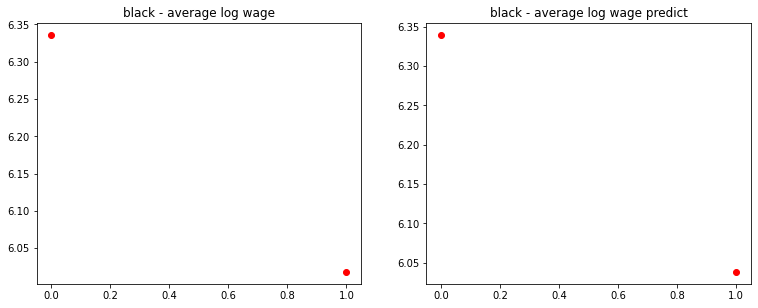

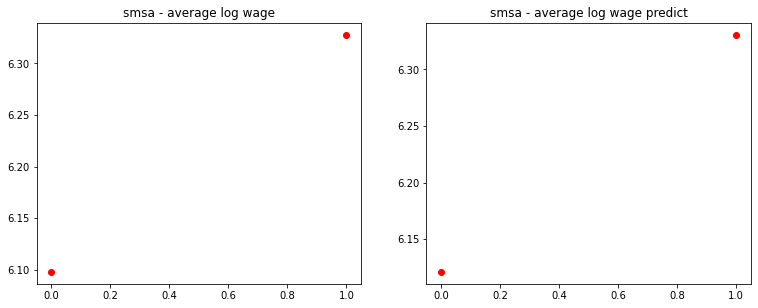

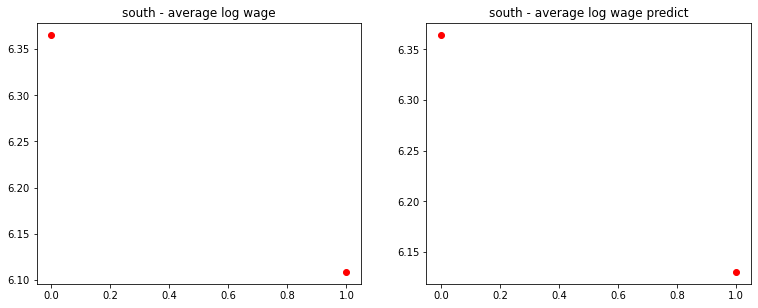

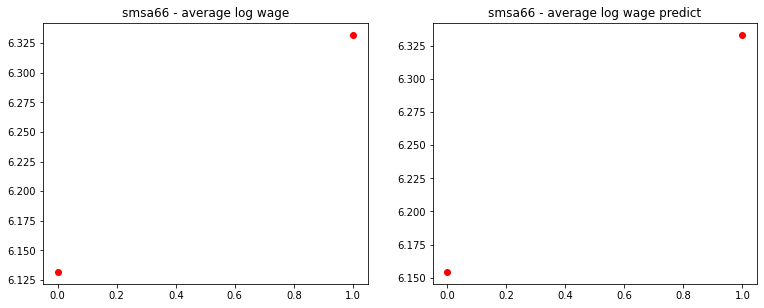

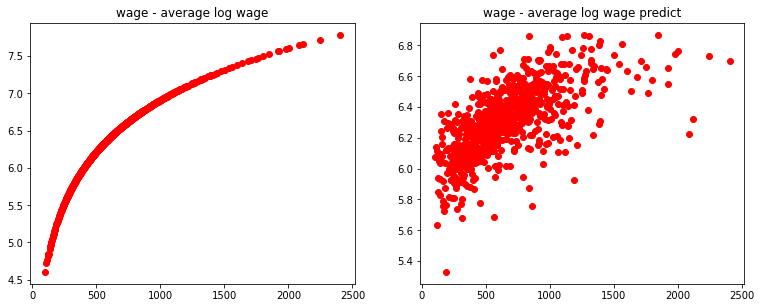

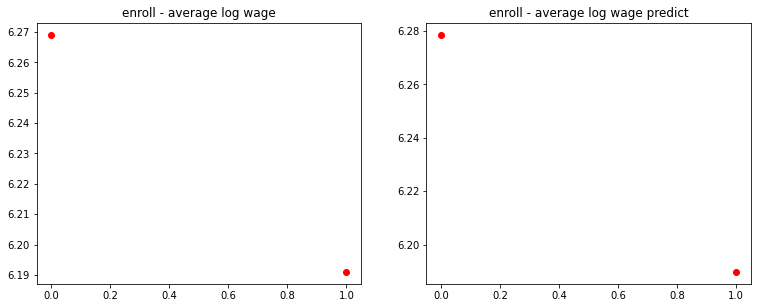

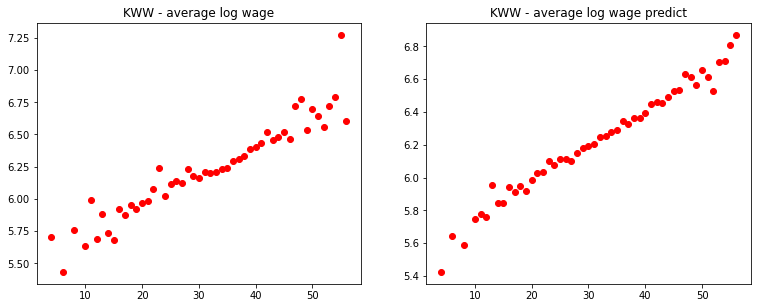

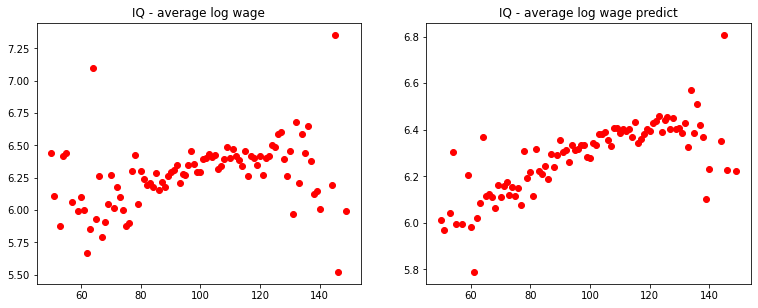

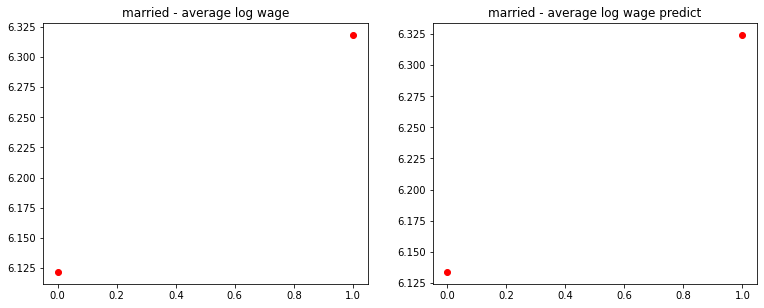

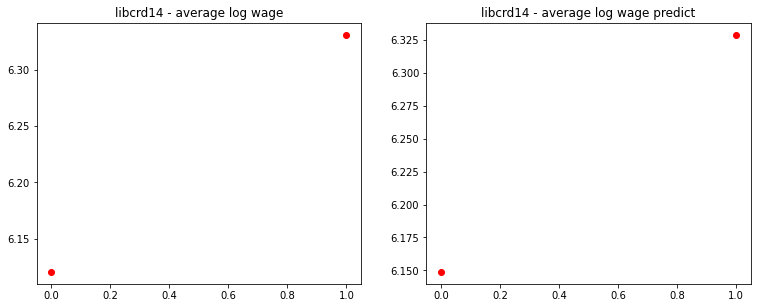

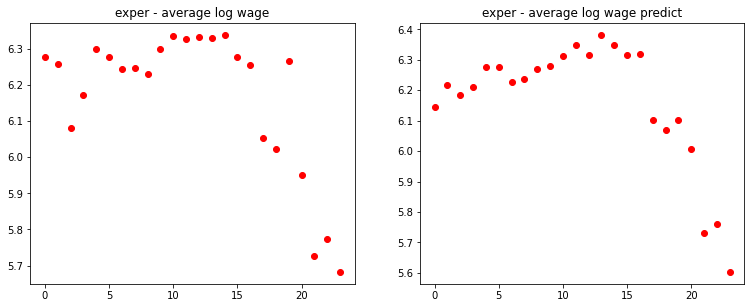

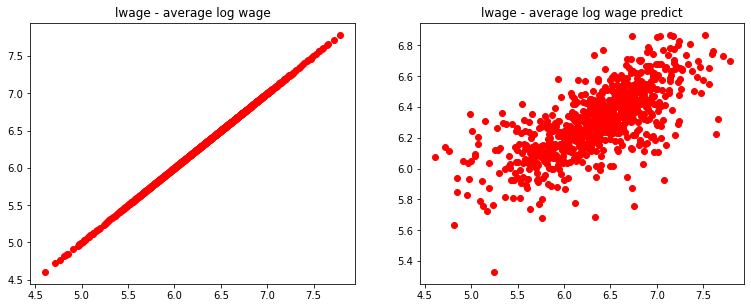

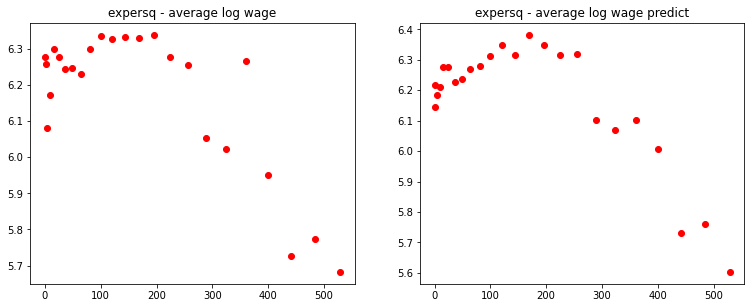

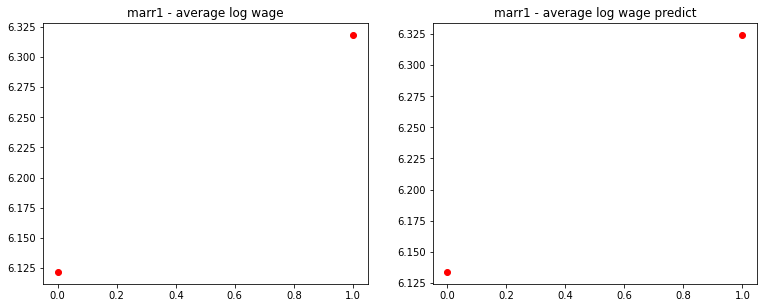

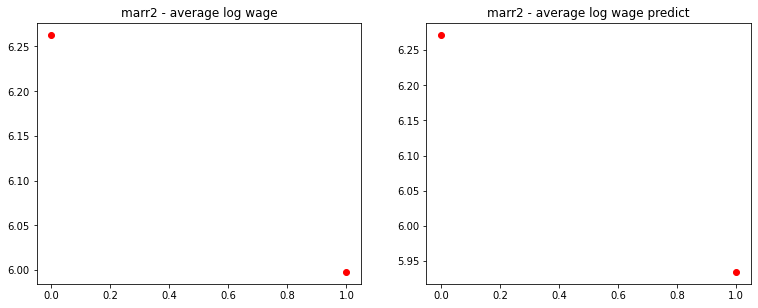

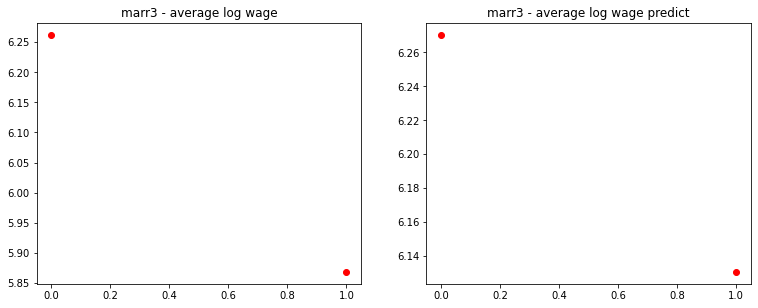

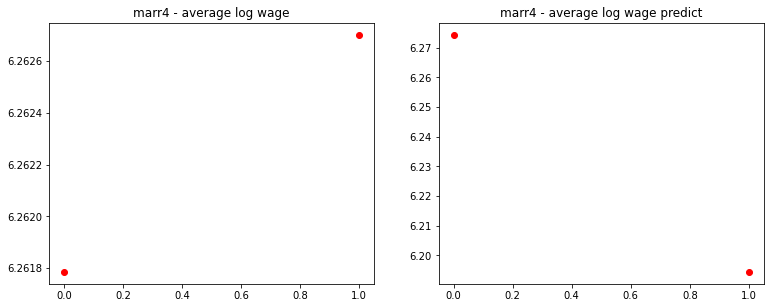

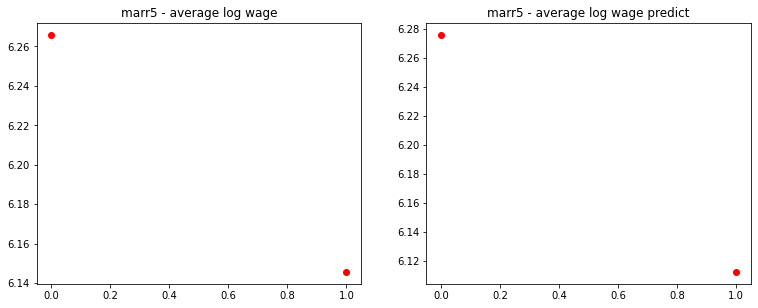

In [35]:
# Display mean of data points
for x in data.columns:
    fig, axis = plt.subplots(1, 2, figsize=[12.8,4.8])
    plt.cla()
    axis[0].set_title(x+" - average log wage")
    axis[1].set_title(x+" - average log wage predict")
    for dtx in set(data[x]):
        y = data[data[x] == dtx]["lwage"].mean()
        axis[0].plot(dtx, y, "ro")
        y = (data[data[x] == dtx][data_vars] @ beta[1:] + beta[0]).mean()
        axis[1].plot(dtx, y, "ro")
    plt.show()